# Convolution 4 layer network

This notebook uses a 4 layer convolution network built using the Keras [sequential model](https://keras.io/getting-started/sequential-model-guide/) to classify images in the 
[CIFAR-10 ](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [1]:
import os
# uncomment the following line to run only on CPU
# restart the Jupyter notebook before each change
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 1 minutes 52 seconds for 5 epochs on GPU
# 20 minutes 38 seconds for 5 epochs on CPU

import numpy as np

In [2]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
import pandas as pd

from sklearn.metrics import confusion_matrix

import seaborn as sns

from keras_tqdm import TQDMNotebookCallback

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
from keras import backend as K
K.image_data_format()

'channels_last'

Loading the CIFAR-10 dataset training and test images

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('There are {} training images each of size {}.'.format(
    x_train.shape[0], x_train.shape[1:3]))

print('There are {} test images.'.format(x_test.shape[0]))

170500096/170498071 [==============================] - 12s 0us/step
There are 50000 training images each of size (32, 32).
There are 10000 test images.


The images are divided into 10 non-overlapping categories

In [5]:
cifar10_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

Matplotlib is used to plot the first 10 images

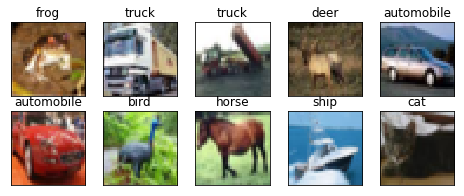

In [6]:
def plot_image(img, title, ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(img)
    ax.set_title(title)
    
nrows = 2
ncols = 5
fig, ax_list = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(w=8, h=3)
for id_x in range(nrows):
    for id_y in range(ncols):
        id_loc = id_x * ncols + id_y
        plot_image(x_train[id_loc], cifar10_names[y_train[id_loc][0]],
                   ax_list[id_x, id_y])

Display the devices available for Tensorflow & Keras

In [7]:
from tensorflow.python.client import device_lib
for item in device_lib.list_local_devices():
    print('name: {}, memory {}'.format(item.name, item.memory_limit))

name: /device:CPU:0, memory 268435456
name: /device:GPU:0, memory 11285974221


In [8]:
num_classes = 10
batch_size = 128
epochs = 100

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

Convert class vectors to binary class matrices

In [9]:
y_train_bin = keras.utils.to_categorical(y_train.squeeze(), num_classes)
y_test_bin = keras.utils.to_categorical(y_test.squeeze(), num_classes)

Create a Convolution model with four layers

In [10]:
K.clear_session()

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [11]:
# model.summary()

In [12]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.rmsprop(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

In [13]:
fit = model.fit(x_train, y_train_bin, batch_size=batch_size, epochs=epochs,
                validation_data=(x_test, y_test_bin), shuffle=True,
                verbose=0, callbacks=[TQDMNotebookCallback()])

Plot the training and validation loss and accuracy

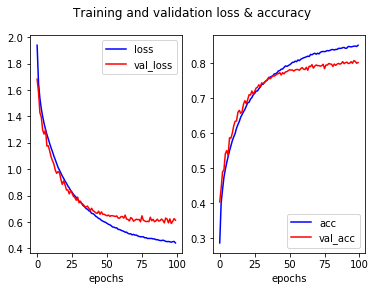

In [14]:
def plot_loss_accuracy(fit):
    
    def plot_measure_by_epoch(fit, item1, item2, ax):
        ax.plot(fit.history[item1], c='blue')
        ax.plot(fit.history[item2], c='red')
        ax.set_xlabel('epochs')
        ax.legend([item1, item2])
        
    fig, ax = plt.subplots(nrows=1, ncols=2)
    plot_measure_by_epoch(fit, 'loss', 'val_loss', ax[0])
    plot_measure_by_epoch(fit, 'acc', 'val_acc', ax[1])
    fig.suptitle('Training and validation loss & accuracy')
    
plot_loss_accuracy(fit)

In [19]:
y_test = y_test.squeeze()
y_predict = model.predict_classes(x_test)
err_idx = np.where(y_test != y_predict)[0]
correct_idx = np.where(y_test == y_predict)[0]

In [20]:
cmatrix = confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cmatrix)
df_cm

,0,1,2,3,4,5,6,7,8,9
0,839,13,23,11,14,4,9,8,55,24
1,16,873,3,4,3,4,8,0,16,73
2,63,4,661,36,87,45,59,23,12,10
3,23,2,52,605,60,136,62,35,12,13
4,17,2,39,37,807,13,30,44,9,2
5,12,1,30,132,49,704,21,39,5,7
6,6,2,28,33,29,15,879,5,2,1
7,8,1,18,25,36,32,5,870,0,5
8,37,25,6,10,4,1,5,2,885,25
9,23,40,4,6,3,2,5,9,15,893


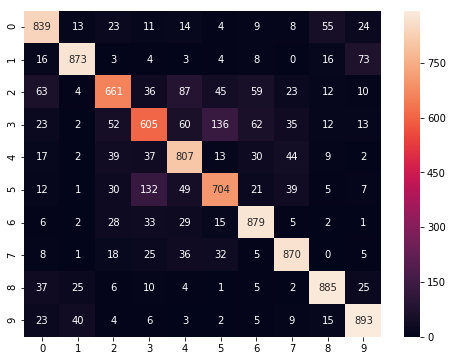

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='.0f', ax=ax)

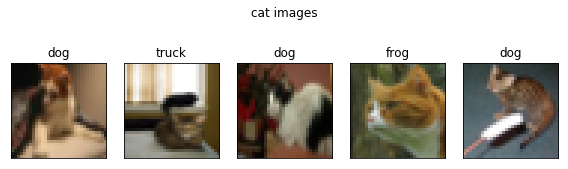

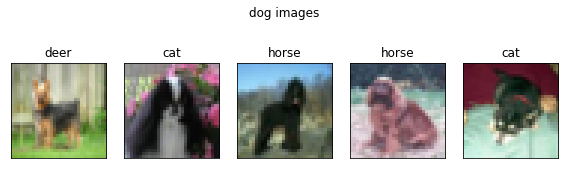

In [22]:
nrows = 2
ncols = 5

def plot_row(ncols, category, selected_idx):
    title = '{} images'.format(cifar10_names[category])
    fig, ax_list = plt.subplots(nrows=1, ncols=ncols)
    fig.set_size_inches(w=8, h=3)
    category_selected = selected_idx[y_test[selected_idx] == category]
    for idx in range(ncols):
        image_idx = category_selected[idx]
        predict_name = cifar10_names[y_predict[image_idx]]
        plot_image(x_test[image_idx], predict_name, ax_list[idx])
    fig.tight_layout()
    fig.suptitle(title)

plot_row(5, 3, err_idx)
plot_row(5, 5, err_idx)

## Links

Confusion matrix
* https://blog.plon.io/tutorials/cifar-10-classification-using-keras-tutorial/

Measuring performance
* https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
* https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/